In [102]:
import os
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.utils.data import DataLoader

datapath = os.path.join('..', 'data')
filterpath = os.path.join(datapath, 'filters-final', '8_19')
num_filters = 8
savepath = 'vae_' + str(num_filters) + '.pt'

def get_dataset():
  weight_dataset = []
  for f, file in tqdm(enumerate(os.listdir(filterpath))):
    filter = torch.load(os.path.join(filterpath, file))
    # import pdb; pdb.set_trace()
    for i in range(num_filters):
      weight_dataset.append(filter['0.weight'][i][0])
  return weight_dataset

num_images = len(os.listdir(filterpath))
dataset = get_dataset()
dataset = torch.stack(dataset, dim=0)
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')

vae_batch_size = 100

x_dim  = 25
hidden_dim = 20
latent_dim = 10

lr = 1e-3

epochs = 50

kwargs = {'num_workers': 1} 

train_dataset = dataset.to(device)
train_loader = DataLoader(dataset=train_dataset, batch_size=vae_batch_size, shuffle=True, **kwargs)

1407it [00:02, 642.64it/s]


In [127]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        # self.LeakyReLU = nn.LeakyReLU(0.2)
        self.tanh = nn.Tanh()

        self.training = True
        
    def forward(self, x):
        h_       = self.tanh(self.FC_input(x))
        h_       = self.tanh(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        # self.LeakyReLU = nn.LeakyReLU(0.2)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        h     = self.tanh(self.FC_hidden(x))
        h     = self.tanh(self.FC_hidden2(h))
        
        x_hat = self.FC_output(h)
        return x_hat

class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        # self.lamb = nn.Parameter(data=torch.Tensor(1), requires_grad=True)
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(device)
loss = torch.nn.MSELoss()


In [128]:
fact = 0

In [129]:
def loss_function(loss, x, x_hat, mean, log_var):
    reproduction_loss = loss(x_hat, x)
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + fact * KLD


optimizer = Adam(model.parameters(), lr=lr)

model.train()

Model(
  (Encoder): Encoder(
    (FC_input): Linear(in_features=25, out_features=20, bias=True)
    (FC_input2): Linear(in_features=20, out_features=20, bias=True)
    (FC_mean): Linear(in_features=20, out_features=10, bias=True)
    (FC_var): Linear(in_features=20, out_features=10, bias=True)
    (tanh): Tanh()
  )
  (Decoder): Decoder(
    (FC_hidden): Linear(in_features=10, out_features=20, bias=True)
    (FC_hidden2): Linear(in_features=20, out_features=20, bias=True)
    (FC_output): Linear(in_features=20, out_features=25, bias=True)
    (tanh): Tanh()
  )
)

In [130]:
for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, x in enumerate(train_loader):
        x = x.view(x.shape[0], x_dim)
        x = x.to(device)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss_val = loss_function(loss, x, x_hat, mean, log_var)
        
        overall_loss += loss_val.item()
        
        loss_val.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*vae_batch_size))
    
torch.save(model.state_dict(), os.path.join(datapath, savepath))

	Epoch 1 complete! 	Average Loss:  0.0070196296500840355
	Epoch 2 complete! 	Average Loss:  0.0022157770568238836
	Epoch 3 complete! 	Average Loss:  0.002093075967526862
	Epoch 4 complete! 	Average Loss:  0.0019584705268165894
	Epoch 5 complete! 	Average Loss:  0.0018470211007765361
	Epoch 6 complete! 	Average Loss:  0.0016807790965374027
	Epoch 7 complete! 	Average Loss:  0.0013513439574411937
	Epoch 8 complete! 	Average Loss:  0.0011094318676207746
	Epoch 9 complete! 	Average Loss:  0.0010021022993272968
	Epoch 10 complete! 	Average Loss:  0.0009277382512976017
	Epoch 11 complete! 	Average Loss:  0.0008773417202090579
	Epoch 12 complete! 	Average Loss:  0.0008532153868249484
	Epoch 13 complete! 	Average Loss:  0.0008330111614694552
	Epoch 14 complete! 	Average Loss:  0.0008198612635689122
	Epoch 15 complete! 	Average Loss:  0.0007989903729009841
	Epoch 16 complete! 	Average Loss:  0.0006720917186300669
	Epoch 17 complete! 	Average Loss:  0.0005083004564845137
	Epoch 18 complete! 	Ave

In [131]:
with torch.no_grad():
    noise = torch.randn(vae_batch_size, latent_dim).to(device)
    generated_images =  model.Decoder(noise)

tensor([[ 0.3570, -0.1492, -0.6505, -0.4931, -0.0405],
        [-0.1027, -1.1166, -1.5005, -1.4174, -1.0611],
        [-0.1080, -1.4067, -1.9748, -2.3882, -1.8519],
        [ 0.4901, -0.6801, -1.8669, -2.2866, -1.7954],
        [ 1.1992,  0.4511, -0.6879, -1.2045, -0.8581]])


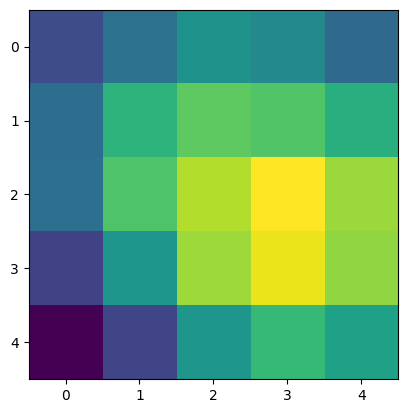

In [132]:
noise = torch.randn(1, latent_dim).to(device) 
res = model.Decoder(noise).view(5, 5).detach().cpu()
print(res)
plt.imshow(-1*res)

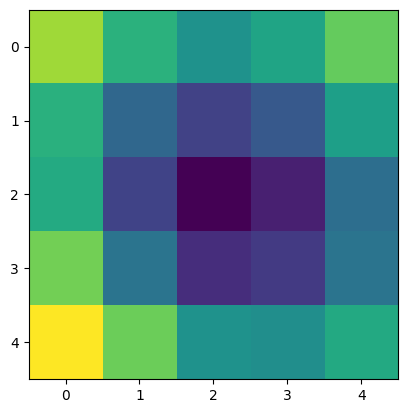

In [133]:
plt.imshow(generated_images[0].view(5, 5))

In [134]:
def visualise_vae(num_rows, generated_images):
  _, axarr = plt.subplots(num_rows, num_filters, figsize=(int(5*(num_filters//8)), num_rows))

  x = generated_images
  x = x.view(vae_batch_size, 5, 5)

  for i in range(num_rows):
    for j in range(num_filters):
      axarr[i, j].set_axis_off()
      axarr[i, j].imshow(x[num_filters*i+j].cpu().numpy(), interpolation=None)

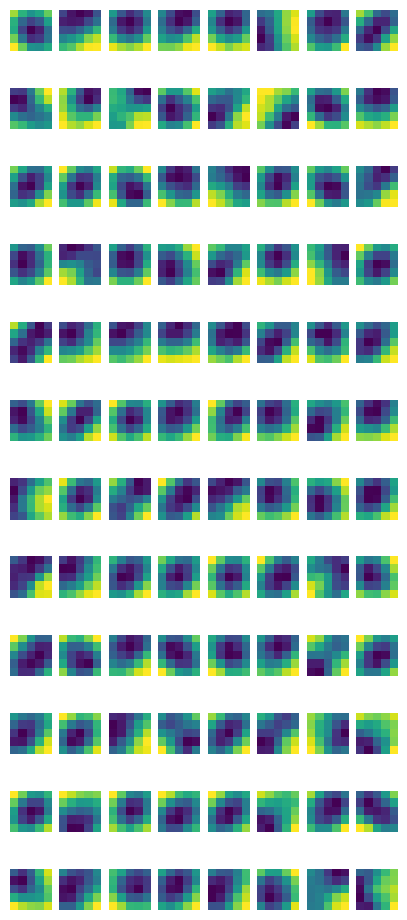

In [135]:
visualise_vae(100//num_filters, generated_images)

In [ ]:
for i in range(len(dataset)):
    print(i, "\n", torch.max(dataset[i]), "\n", torch.min(dataset[i]), "\n\n")

In [155]:
k = 33
print(torch.mean(dataset[100*k:100*(k+1)]))
print(torch.std(dataset[100*k:100*(k+1)]))

tensor(-0.1181, device='cuda:0')
tensor(1.3148, device='cuda:0')


In [136]:
def debug(x):
    for i in range(len(x)):
        print(i, "\n", torch.max(x[i]), "\n", torch.min(x[i]), "\n\n")

In [ ]:
debug(generated_images)